# Tutorial 2 - RNN Time Series

In this notebook, we will predict the weather temperature. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

weather = pd.read_csv('weather.csv')

weather.head()

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.2,5.040000,25.795000,99.9,1011.980000
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.2,6.293333,25.445000,99.9,1012.131667
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.2,5.501667,25.223333,99.9,1012.365000
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.2,4.201667,25.075000,99.9,1012.276667
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.2,5.365000,24.928333,99.9,1012.030000


In [3]:
# Convert the temp to Fahrenheit:

weather['Air Temp F'] = weather['Air Temp.']*1.8 + 32

In [4]:
weather

,date,hour,NO2,CO,O3,NO,PM2.5,PM10,Air Temp.,Air Hum.,Air Pres.,Air Temp F
0,4/25/2021,0,0.039817,0.080700,-0.000867,0.009800,0.200,5.040000,25.795000,99.900,1011.980000,78.431
1,4/25/2021,1,0.035900,0.092217,-0.000267,0.009833,0.200,6.293333,25.445000,99.900,1012.131667,77.801
2,4/25/2021,2,0.028083,0.062750,0.002517,0.012883,0.200,5.501667,25.223333,99.900,1012.365000,77.402
3,4/25/2021,3,0.025633,0.042300,0.004550,0.014233,0.200,4.201667,25.075000,99.900,1012.276667,77.135
4,4/25/2021,4,0.023717,0.036883,0.006267,0.015417,0.200,5.365000,24.928333,99.900,1012.030000,76.871
...,...,...,...,...,...,...,...,...,...,...,...,...
7952,4/19/2022,19,0.007500,0.135750,0.035250,0.044000,2.150,9.275000,28.375000,39.175,1016.000000,83.075
7953,4/19/2022,20,0.024000,0.145750,0.025250,0.035000,2.525,16.100000,28.575000,37.275,1015.550000,83.435
7954,4/19/2022,21,0.013400,0.147200,0.038800,0.022200,2.260,12.980000,28.440000,32.740,1015.340000,83.192
7955,4/19/2022,22,0.023000,0.126000,0.039000,0.014000,2.350,11.375000,28.150000,33.250,1015.600000,82.670


In [5]:
#Drop the columns we don't need

weather = weather.drop(['NO2', 'CO', 'O3', 'NO', 'PM2.5', 'PM10', 'Air Temp.',
              'Air Hum.', 'Air Pres.'], axis=1)

In [6]:
weather

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871
...,...,...,...
7952,4/19/2022,19,83.075
7953,4/19/2022,20,83.435
7954,4/19/2022,21,83.192
7955,4/19/2022,22,82.670


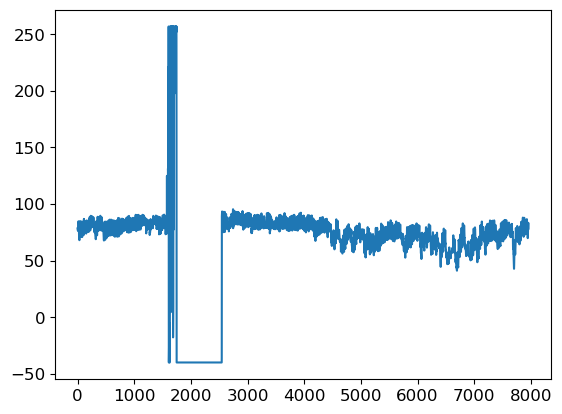

In [7]:
#Plot temp

plt.plot(weather['Air Temp F'])
plt.show()

# Data Cleanup

In [8]:
# Values higher than 100 degrees are probably incorrect readings

weather[weather['Air Temp F']>100]

,date,hour,Air Temp F
1578,6/29/2021,21,124.865
1582,6/30/2021,1,108.674
1595,6/30/2021,14,112.001
1596,6/30/2021,15,131.294
1597,6/30/2021,16,128.849
...,...,...,...
1742,7/6/2021,17,256.820
1743,7/6/2021,18,256.820
1744,7/6/2021,19,251.894
1745,7/6/2021,20,256.820


In [9]:
# Convert all values higher than 100 degrees to null values

weather['Air Temp F'] = np.where(weather['Air Temp F']>100, np.nan, weather['Air Temp F'])

In [10]:
# Values lower than 30 degrees are probably incorrect readings. Convert them to null

weather['Air Temp F'] = np.where(weather['Air Temp F']<30, np.nan, weather['Air Temp F'])

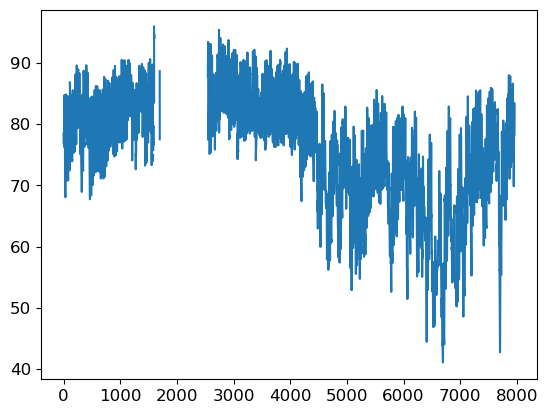

In [11]:
plt.plot(weather['Air Temp F'])
plt.show()

In [12]:
# Remove all null values

weather = weather.dropna().reset_index(drop=True)

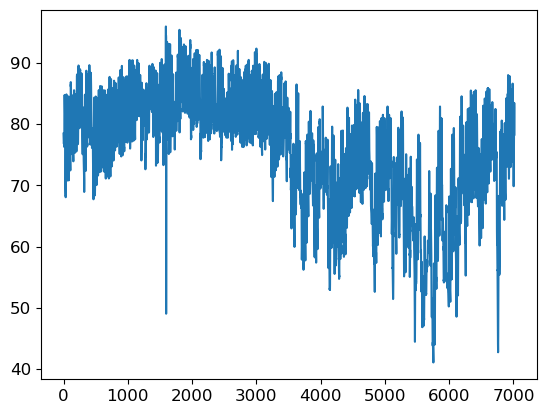

In [13]:
plt.plot(weather['Air Temp F'])
plt.show()

## RESHAPE the data set!

In [14]:
weather.shape

(7017, 3)

In [15]:
# Note that not all days have 24 readings. Some are missing.

weather.shape[0]/24

292.375

In [16]:
weather.groupby(['date']).count()

,hour,Air Temp F
date,,
1/1/2022,24,24
1/10/2022,24,24
1/11/2022,24,24
1/12/2022,24,24
1/13/2022,24,24
...,...,...
9/5/2021,24,24
9/6/2021,24,24
9/7/2021,24,24


In [17]:
# Find the reading count for each day

hour_count = pd.DataFrame(weather.groupby(['date']).count()['hour'])

hour_count

,hour
date,
1/1/2022,24
1/10/2022,24
1/11/2022,24
1/12/2022,24
1/13/2022,24
...,...
9/5/2021,24
9/6/2021,24
9/7/2021,24


In [18]:
# Find the reading counts that are less than 24

hour_count[hour_count['hour']<24]

,hour
date,
3/18/2022,7
4/11/2022,9
4/14/2022,10
6/21/2021,21
6/29/2021,23
6/30/2021,16
7/1/2021,1
7/2/2021,3
7/3/2021,3


In [19]:
# Identify the dates of these records

hour_count[hour_count['hour']<24].index.values

array(['3/18/2022', '4/11/2022', '4/14/2022', '6/21/2021', '6/29/2021',
       '6/30/2021', '7/1/2021', '7/2/2021', '7/3/2021', '7/4/2021',
       '8/10/2021'], dtype=object)

In [20]:
# Find the corresponding index values in the original data set

indexes = weather[weather['date'].isin(hour_count[hour_count['hour']<24].index.values)]

indexes

,date,hour,Air Temp F
1368,6/21/2021,0,84.386
1369,6/21/2021,1,84.137
1370,6/21/2021,2,83.993
1371,6/21/2021,3,83.549
1372,6/21/2021,4,83.210
...,...,...,...
6892,4/14/2022,19,83.732
6893,4/14/2022,20,82.715
6894,4/14/2022,21,81.590
6895,4/14/2022,22,82.085


In [21]:
# Remove these rows from the data set.

weather = weather.drop(indexes.index, axis=0).reset_index(drop=True)

weather.shape

(6912, 3)

In [22]:
weather.head()

,date,hour,Air Temp F
0,4/25/2021,0,78.431
1,4/25/2021,1,77.801
2,4/25/2021,2,77.402
3,4/25/2021,3,77.135
4,4/25/2021,4,76.871


In [23]:
# All remaining days have 24 readings (for 24 hours)
# There are a total of 288 days

weather.shape[0]/24

288.0

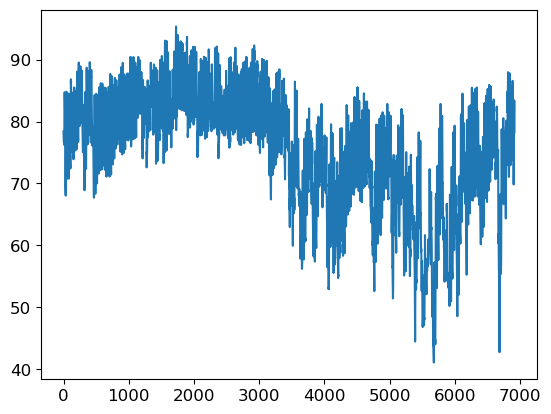

In [24]:
plt.plot(weather['Air Temp F'])
plt.show()

In [25]:
# Re-organize the data set by day and hours

temp = np.array(weather['Air Temp F']).reshape(288,24)

temp

array([[78.431     , 77.801     , 77.40199999, ..., 82.54700001,
        81.716     , 79.196     ],
       [76.02200001, 73.121     , 71.68699999, ..., 84.82699999,
        84.57499999, 82.52900001],
       [80.843     , 78.87500001, 77.05099999, ..., 84.52700001,
        83.99899999, 82.44199999],
       ...,
       [78.26      , 77.54      , 77.495     , ..., 83.98999999,
        83.3       , 79.736     ],
       [78.305     , 77.63      , 77.432     , ..., 84.245     ,
        83.084     , 79.376     ],
       [77.27      , 76.136     , 75.29      , ..., 83.192     ,
        82.67      , 78.26      ]])

In [26]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,24,1))

temp_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,78.431,77.801,77.402,77.135,76.871,76.814,76.892,76.925,76.580,76.343,...,81.584,81.575,82.445,84.731,84.272,83.252,83.447,82.547,81.716,79.196
1,76.022,73.121,71.687,70.664,69.560,68.864,68.603,68.360,68.360,68.267,...,75.500,77.594,79.691,81.458,83.012,84.080,84.323,84.827,84.575,82.529
2,80.843,78.875,77.051,74.675,73.499,72.950,72.221,71.330,71.048,70.766,...,77.222,79.241,80.933,81.602,82.478,83.795,84.146,84.527,83.999,82.442
3,80.576,78.731,76.739,74.819,73.829,73.052,72.575,71.876,71.306,70.793,...,77.657,79.562,81.014,81.848,82.955,83.813,83.996,84.437,82.913,80.210
4,78.632,77.618,76.040,75.278,74.918,74.561,73.859,73.127,72.785,72.575,...,79.859,82.376,85.808,86.831,86.108,86.459,86.003,84.902,84.413,81.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,76.910,76.145,75.590,75.380,75.245,74.525,74.750,74.300,74.030,73.040,...,83.300,84.920,81.428,83.210,83.750,85.400,86.225,87.980,86.540,76.784
284,75.200,77.585,77.060,76.055,74.948,74.030,73.400,72.500,71.915,71.600,...,77.108,79.916,83.012,83.930,83.948,86.000,87.215,87.800,86.540,80.168
285,78.260,77.540,77.495,77.540,77.540,76.730,75.920,75.245,74.525,73.400,...,80.330,82.625,84.695,85.640,85.460,84.992,84.470,83.990,83.300,79.736
286,78.305,77.630,77.432,77.135,77.360,76.640,76.505,75.980,75.065,74.120,...,80.810,83.444,84.155,83.435,80.510,86.585,85.235,84.245,83.084,79.376


# Reshape for Standardizing Data

In [27]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(6912, 1)

In [28]:
temp_1feature

array([[78.431     ],
       [77.801     ],
       [77.40199999],
       ...,
       [83.192     ],
       [82.67      ],
       [78.26      ]])

## Standardize the values

In [29]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

## Reshape the data back to 24-hour format

In [30]:
temp_reshaped = temp_std.reshape(288,24)

temp_reshaped.shape

(288, 24)

In [31]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,24,1))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.391232,0.325683,0.284169,0.256388,0.228920,0.222990,0.231105,0.234539,0.198643,0.173984,...,0.719288,0.718351,0.808871,1.046720,0.998963,0.892836,0.913125,0.819484,0.733022,0.470827
1,0.140586,-0.161251,-0.310453,-0.416891,-0.531758,-0.604174,-0.631330,-0.656613,-0.656613,-0.666289,...,0.086274,0.304145,0.522329,0.706178,0.867865,0.978986,1.004269,1.056708,1.030489,0.817611
2,0.642190,0.437428,0.247649,0.000436,-0.121922,-0.179043,-0.254892,-0.347597,-0.376938,-0.406279,...,0.265440,0.475509,0.651554,0.721161,0.812305,0.949333,0.985853,1.025494,0.970558,0.808559
3,0.614410,0.422445,0.215186,0.015419,-0.087587,-0.168430,-0.218060,-0.290788,-0.350094,-0.403470,...,0.310700,0.508907,0.659982,0.746756,0.861934,0.951206,0.970246,1.016130,0.857565,0.576329
4,0.412145,0.306642,0.142458,0.063175,0.025719,-0.011425,-0.084465,-0.160627,-0.196210,-0.218060,...,0.539809,0.801692,1.158777,1.265216,1.189991,1.226511,1.179066,1.064511,1.013633,0.703681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.232978,0.153383,0.095638,0.073788,0.059742,-0.015171,0.008239,-0.038581,-0.066674,-0.169679,...,0.897830,1.066384,0.703057,0.888466,0.944651,1.116326,1.202164,1.384764,1.234938,0.219868
284,0.055060,0.303209,0.248585,0.144019,0.028840,-0.066674,-0.132222,-0.225864,-0.286730,-0.319505,...,0.253579,0.545740,0.867865,0.963379,0.965252,1.178754,1.305169,1.366036,1.234938,0.571959
285,0.373440,0.298527,0.293845,0.298527,0.298527,0.214250,0.129973,0.059742,-0.015171,-0.132222,...,0.588814,0.827599,1.042974,1.141297,1.122569,1.073876,1.019564,0.969622,0.897830,0.527011
286,0.378122,0.307891,0.287290,0.256388,0.279799,0.204886,0.190840,0.136216,0.041014,-0.057309,...,0.638756,0.912813,0.986789,0.911876,0.607543,1.239620,1.099159,0.996153,0.875356,0.489555


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random spli because each day as an independent sample.

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_reshaped, test_size=0.3)

# if we neede to maintain the ordering of the data, we can use the following code to split the data
#split_point = int(len(temp_reshaped)*0.7)
#train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [33]:
train.shape

(201, 24)

In [34]:
train[:2]

array([[-1.98631703, -1.8364912 , -1.85053737, -1.75689623, -1.90672206,
        -1.94886057, -1.92545029, -1.85521943, -1.79435268, -1.79435268,
        -1.76157828, -1.7709424 , -1.81776297, -1.87394766, -1.84117326,
        -1.82712708, -1.80839886, -1.74285005, -1.65857302, -1.55556776,
        -1.49001896, -1.46192662, -1.45256251, -1.42447016],
       [ 0.40153216,  0.44835273,  0.48580919,  0.47644508,  0.49985536,
         0.51858359,  0.54199388,  0.52794771,  0.54199388,  0.54667593,
         0.51858359,  0.57476828,  0.79014291,  0.60754268,  0.63095296,
         0.41089627,  0.66372737,  0.99147137,  1.03829194,  1.34730772,
         1.38944624,  1.29580509,  1.0757484 ,  1.01956372]])

In [35]:
test.shape

(87, 24)

In [36]:
test[:2]

array([[ 1.0236215 ,  0.4564683 ,  0.43274588,  0.54917303,  0.52014428,
         0.53824823,  0.60847909,  0.52825984,  0.44179785,  0.32537069,
         0.27043456,  0.38654958,  0.59536933,  0.77235109,  0.89096321,
         0.95994552,  1.15908902,  1.29642937,  1.46498343,  1.47715677,
         1.54613909,  1.49744569,  1.30329638,  1.18093862],
       [ 0.12529078,  0.05037787, -0.04326328,  0.01760347, -0.09008385,
        -0.17436088, -0.23522762, -0.19308911, -0.27268408, -0.38505346,
        -0.40378168, -0.38973551, -0.38505346, -0.20245322, -0.05262739,
         0.00355729,  0.07378815,  0.1674293 ,  0.20956781,  0.31257307,
         0.34534747,  0.3968501 ,  0.24234221,  0.05974198]])

# Create Input and Target values

The first 23 hours will be input to predict the 24th hour reading (i.e., target)

In [37]:
# The first 23 columns (from 0 to 22) are inputs

train_inputs = train[:,:23]


pd.DataFrame(train_inputs, columns=np.arange(0,23,1))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-1.986317,-1.836491,-1.850537,-1.756896,-1.906722,-1.948861,-1.925450,-1.855219,-1.794353,-1.794353,...,-1.873948,-1.841173,-1.827127,-1.808399,-1.742850,-1.658573,-1.555568,-1.490019,-1.461927,-1.452563
1,0.401532,0.448353,0.485809,0.476445,0.499855,0.518584,0.541994,0.527948,0.541994,0.546676,...,0.607543,0.630953,0.410896,0.663727,0.991471,1.038292,1.347308,1.389446,1.295805,1.075748
2,-1.195049,-1.199731,-1.265280,-1.251234,-1.255916,-1.293373,-1.293373,-1.340193,-1.382332,-1.391696,...,-1.424470,-1.330829,-1.363603,-1.419788,-1.424470,-1.316783,-1.326147,-1.059270,-1.031177,-1.293373
3,-1.616435,-1.602388,-1.635163,-1.653891,-1.761578,-1.799035,-1.799035,-1.799035,-1.850537,-1.883312,...,-1.948861,-1.911404,-1.958225,-1.770942,-1.387014,-1.054588,-0.829849,-0.956264,-0.829849,-1.457245
4,0.982107,0.921241,0.696502,0.499855,0.401532,0.307891,0.270435,0.247024,0.232978,0.209568,...,0.598179,0.762051,0.949333,1.057020,1.234938,1.295805,1.239620,1.202164,1.155343,1.206846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017603,-0.179043,-0.207135,-0.193089,-0.263320,-0.314823,-0.417828,-0.469330,-0.502105,-0.539561,...,-0.605110,-0.464648,-0.239910,0.055060,0.396850,0.626271,0.776097,0.902512,0.804189,0.443671
197,1.234938,1.099159,0.935287,0.799507,0.752686,0.748004,0.724594,0.724594,0.701184,0.701184,...,1.089795,1.281759,1.436267,1.623549,1.717190,1.867016,2.040252,2.124529,2.152622,2.040252
198,0.209568,0.312573,0.335983,0.335983,0.321937,0.247024,0.228296,0.214250,0.232978,0.275117,...,0.719912,0.949333,1.127251,1.375400,1.637595,1.628231,1.562682,1.431585,1.333262,1.230256
199,-0.001125,0.012921,-0.052627,-0.282048,-0.394418,-0.483377,-0.558290,-0.633202,-0.684705,-0.722162,...,-0.427192,-0.164997,0.289163,0.527948,0.635635,0.930605,0.986789,1.024246,1.103841,0.888466


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [38]:
train_inputs

array([[-1.98631703e+00, -1.83649120e+00, -1.85053737e+00, ...,
        -1.49001896e+00, -1.46192662e+00, -1.45256251e+00],
       [ 4.01532160e-01,  4.48352732e-01,  4.85809190e-01, ...,
         1.38944624e+00,  1.29580509e+00,  1.07574840e+00],
       [-1.19504936e+00, -1.19973142e+00, -1.26528022e+00, ...,
        -1.05926970e+00, -1.03117735e+00, -1.29337256e+00],
       ...,
       [ 2.09567813e-01,  3.12573072e-01,  3.35983359e-01, ...,
         1.43158475e+00,  1.33326155e+00,  1.23025629e+00],
       [-1.12476250e-03,  1.29214092e-02, -5.26273921e-02, ...,
         1.02424577e+00,  1.10384075e+00,  8.88466112e-01],
       [ 7.43322338e-01,  6.63727365e-01,  5.93496507e-01, ...,
         9.63379028e-01,  1.08979457e+00,  8.60373769e-01]])

In [39]:
train_inputs.shape 

(201, 23)

In [40]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(201, 23, 1)

In [41]:
train_x

array([[[-1.98631703e+00],
        [-1.83649120e+00],
        [-1.85053737e+00],
        ...,
        [-1.49001896e+00],
        [-1.46192662e+00],
        [-1.45256251e+00]],

       [[ 4.01532160e-01],
        [ 4.48352732e-01],
        [ 4.85809190e-01],
        ...,
        [ 1.38944624e+00],
        [ 1.29580509e+00],
        [ 1.07574840e+00]],

       [[-1.19504936e+00],
        [-1.19973142e+00],
        [-1.26528022e+00],
        ...,
        [-1.05926970e+00],
        [-1.03117735e+00],
        [-1.29337256e+00]],

       ...,

       [[ 2.09567813e-01],
        [ 3.12573072e-01],
        [ 3.35983359e-01],
        ...,
        [ 1.43158475e+00],
        [ 1.33326155e+00],
        [ 1.23025629e+00]],

       [[-1.12476250e-03],
        [ 1.29214092e-02],
        [-5.26273921e-02],
        ...,
        [ 1.02424577e+00],
        [ 1.10384075e+00],
        [ 8.88466112e-01]],

       [[ 7.43322338e-01],
        [ 6.63727365e-01],
        [ 5.93496507e-01],
        ...,
        

## Set the target

In [42]:
# The last column (23) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['23'])

,23
0,-1.424470
1,1.019564
2,-1.485337
3,-1.962907
4,1.047656
...,...
196,0.181475
197,0.410896
198,0.982107
199,0.560722


## Repeat for TEST

In [43]:
test.shape

(87, 24)

In [44]:
# The first 23 columns (from 0 to 22) are inputs

test_inputs = test[:,:23]

In [45]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(87, 23, 1)

In [46]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['23'])

,23
0,1.180939
1,0.059742
2,-1.003085
3,0.624086
4,-0.347597
...,...
82,-1.892676
83,1.145979
84,-0.033899
85,1.057020


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [47]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[23, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
7/7 [==============================] - 1s 3ms/step - loss: 0.1567
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0974
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 13/100
7/7 [==============================] - 0s 3ms/st

### Predictions

In [48]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 3ms/step


In [49]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [50]:
comparison

,actual,predicted
0,86.021,83.223801
1,75.245,75.395531
2,65.030,68.110481
3,80.669,82.823120
4,71.330,71.504448
...,...,...
82,56.480,60.468613
83,85.685,85.675346
84,74.345,74.541199
85,84.830,84.959198


In [51]:
mean_squared_error(comparison['actual'], comparison['predicted'])

3.06674664777204

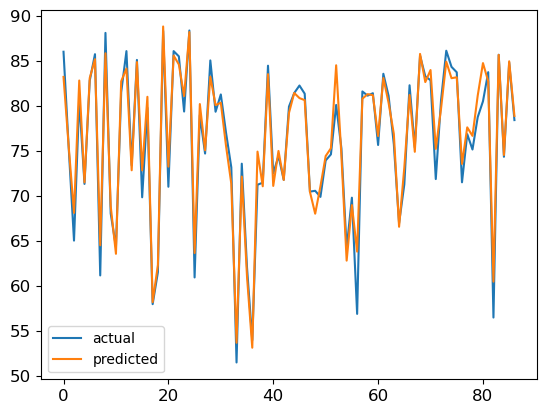

In [52]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [53]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 2s 7ms/step - loss: 0.6146
Epoch 2/30
7/7 [==============================] - 0s 6ms/step - loss: 0.5532
Epoch 3/30
7/7 [==============================] - 0s 7ms/step - loss: 0.5082
Epoch 4/30
7/7 [==============================] - 0s 6ms/step - loss: 0.4560
Epoch 5/30
7/7 [==============================] - 0s 7ms/step - loss: 0.4074
Epoch 6/30
7/7 [==============================] - 0s 7ms/step - loss: 0.3550
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 0.3002
Epoch 8/30
7/7 [==============================] - 0s 7ms/step - loss: 0.2305
Epoch 9/30
7/7 [==============================] - 0s 7ms/step - loss: 0.1592
Epoch 10/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0907
Epoch 11/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0632
Epoch 12/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0507
Epoch 13/30
7/7 [==============================] - 0s 7ms/step - loss: 0.

### Predictions

In [55]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 0s 4ms/step


In [56]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [57]:
comparison

,actual,predicted
0,86.021,84.586479
1,75.245,74.122971
2,65.030,68.690193
3,80.669,83.008324
4,71.330,71.109932
...,...,...
82,56.480,59.517059
83,85.685,86.454742
84,74.345,74.523834
85,84.830,84.710869


In [58]:
mean_squared_error(comparison['actual'], comparison['predicted'])

2.419113458350609

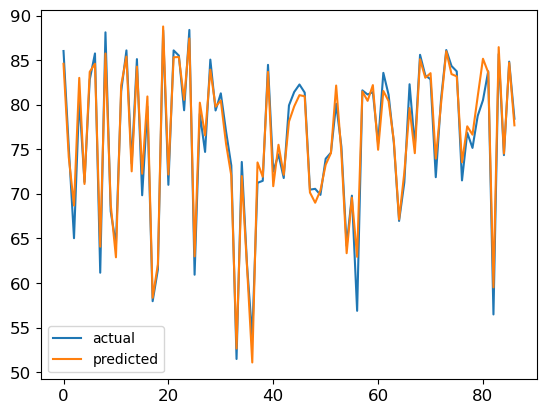

In [59]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [60]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 3s 14ms/step - loss: 0.8577
Epoch 2/30
7/7 [==============================] - 0s 15ms/step - loss: 0.5489
Epoch 3/30
7/7 [==============================] - 0s 15ms/step - loss: 0.4350
Epoch 4/30
7/7 [==============================] - 0s 15ms/step - loss: 0.3817
Epoch 5/30
7/7 [==============================] - 0s 15ms/step - loss: 0.3110
Epoch 6/30
7/7 [==============================] - 0s 14ms/step - loss: 0.1819
Epoch 7/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0876
Epoch 8/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0633
Epoch 9/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0518
Epoch 10/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0433
Epoch 11/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0408
Epoch 12/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0401
Epoch 13/30
7/7 [==============================] - 0s 15ms/st

### Predictions

In [62]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 0s 7ms/step


In [63]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [64]:
comparison

,actual,predicted
0,86.021,84.560287
1,75.245,75.087463
2,65.030,68.624695
3,80.669,83.304848
4,71.330,72.193268
...,...,...
82,56.480,59.861443
83,85.685,85.670570
84,74.345,74.839867
85,84.830,84.811447


In [65]:
mean_squared_error(comparison['actual'], comparison['predicted'])

2.532165401589725

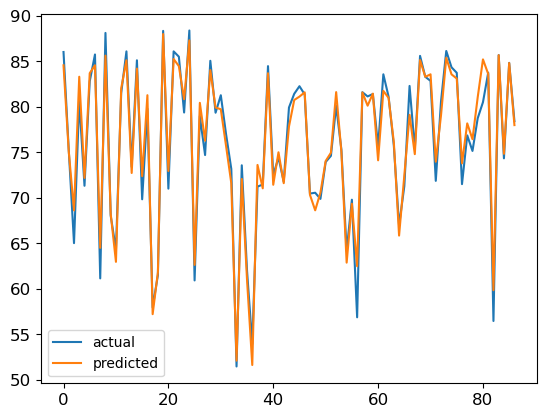

In [66]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [67]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[23, 1]),
    keras.layers.Dense(1, activation=None)
])

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 3s 14ms/step - loss: 0.6799
Epoch 2/30
7/7 [==============================] - 0s 12ms/step - loss: 0.5403
Epoch 3/30
7/7 [==============================] - 0s 13ms/step - loss: 0.3899
Epoch 4/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2840
Epoch 5/30
7/7 [==============================] - 0s 13ms/step - loss: 0.1942
Epoch 6/30
7/7 [==============================] - 0s 11ms/step - loss: 0.1490
Epoch 7/30
7/7 [==============================] - 0s 13ms/step - loss: 0.1114
Epoch 8/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0987
Epoch 9/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0899
Epoch 10/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0829
Epoch 11/30
7/7 [==============================] - 0s 12ms/step - loss: 0.0785
Epoch 12/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0755
Epoch 13/30
7/7 [==============================] - 0s 13ms/st

### Predictions

In [69]:
#Predict:
y_pred = model.predict(test_x)


3/3 [==============================] - 0s 5ms/step


In [70]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [71]:
mean_squared_error(comparison['actual'], comparison['predicted'])

4.596917362957845

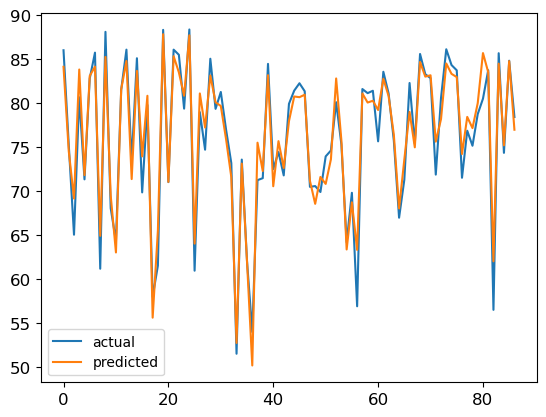

In [72]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [73]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[23, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 8s 25ms/step - loss: 0.6014
Epoch 2/30
7/7 [==============================] - 0s 27ms/step - loss: 0.2484
Epoch 3/30
7/7 [==============================] - 0s 27ms/step - loss: 0.1302
Epoch 4/30
7/7 [==============================] - 0s 27ms/step - loss: 0.1291
Epoch 5/30
7/7 [==============================] - 0s 29ms/step - loss: 0.1039
Epoch 6/30
7/7 [==============================] - 0s 28ms/step - loss: 0.1055
Epoch 7/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0944
Epoch 8/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0927
Epoch 9/30
7/7 [==============================] - 0s 29ms/step - loss: 0.0877
Epoch 10/30
7/7 [==============================] - 0s 29ms/step - loss: 0.0844
Epoch 11/30
7/7 [==============================] - 0s 30ms/step - loss: 0.0823
Epoch 12/30
7/7 [==============================] - 0s 28ms/step - loss: 0.0806
Epoch 13/30
7/7 [==============================] - 0s 29ms/st

### Predictions

In [75]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 10ms/step


In [76]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [77]:
mean_squared_error(comparison['actual'], comparison['predicted'])

6.316218680468387

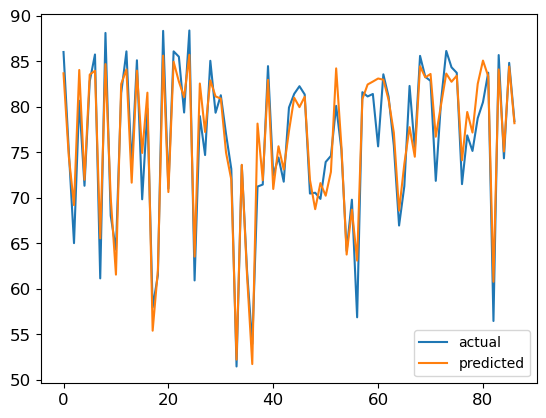

In [78]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [79]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [80]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 5s 25ms/step - loss: 0.6629
Epoch 2/30
7/7 [==============================] - 0s 23ms/step - loss: 0.4742
Epoch 3/30
7/7 [==============================] - 0s 24ms/step - loss: 0.3373
Epoch 4/30
7/7 [==============================] - 0s 24ms/step - loss: 0.2205
Epoch 5/30
7/7 [==============================] - 0s 25ms/step - loss: 0.1330
Epoch 6/30
7/7 [==============================] - 0s 25ms/step - loss: 0.0840
Epoch 7/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0681
Epoch 8/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0645
Epoch 9/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0614
Epoch 10/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0638
Epoch 11/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0604
Epoch 12/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0622
Epoch 13/30
7/7 [==============================] - 0s 24ms/st

### Predictions

In [81]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 8ms/step


In [82]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [83]:
mean_squared_error(comparison['actual'], comparison['predicted'])

4.755109849547803

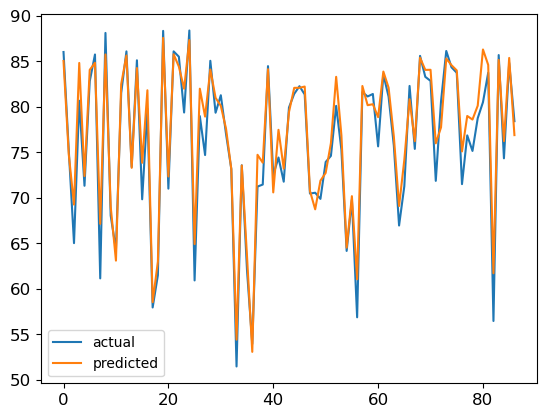

In [84]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [85]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[23, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [86]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 6s 25ms/step - loss: 0.6676
Epoch 2/30
7/7 [==============================] - 0s 24ms/step - loss: 0.4497
Epoch 3/30
7/7 [==============================] - 0s 23ms/step - loss: 0.2814
Epoch 4/30
7/7 [==============================] - 0s 24ms/step - loss: 0.1412
Epoch 5/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0778
Epoch 6/30
7/7 [==============================] - 0s 23ms/step - loss: 0.0848
Epoch 7/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0706
Epoch 8/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0740
Epoch 9/30
7/7 [==============================] - 0s 23ms/step - loss: 0.0670
Epoch 10/30
7/7 [==============================] - 0s 24ms/step - loss: 0.0659
Epoch 11/30
7/7 [==============================] - 0s 23ms/step - loss: 0.0626
Epoch 12/30
7/7 [==============================] - 0s 25ms/step - loss: 0.0621
Epoch 13/30
7/7 [==============================] - 0s 23ms/st

### Predictions

In [87]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 7ms/step


In [88]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [89]:
mean_squared_error(comparison['actual'], comparison['predicted'])

2.706614485343944

# Forecasting Several Steps Ahead

## Now let's create an RNN that predicts 12 next values at once:

In [90]:
# The first 12 columns (from 0 to 11) are inputs

train_inputs = train[:,:12]

pd.DataFrame(train_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.986317,-1.836491,-1.850537,-1.756896,-1.906722,-1.948861,-1.925450,-1.855219,-1.794353,-1.794353,-1.761578,-1.770942
1,0.401532,0.448353,0.485809,0.476445,0.499855,0.518584,0.541994,0.527948,0.541994,0.546676,0.518584,0.574768
2,-1.195049,-1.199731,-1.265280,-1.251234,-1.255916,-1.293373,-1.293373,-1.340193,-1.382332,-1.391696,-1.401060,-1.424470
3,-1.616435,-1.602388,-1.635163,-1.653891,-1.761578,-1.799035,-1.799035,-1.799035,-1.850537,-1.883312,-1.939496,-1.972271
4,0.982107,0.921241,0.696502,0.499855,0.401532,0.307891,0.270435,0.247024,0.232978,0.209568,0.200204,0.167429
...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017603,-0.179043,-0.207135,-0.193089,-0.263320,-0.314823,-0.417828,-0.469330,-0.502105,-0.539561,-0.548925,-0.516151
197,1.234938,1.099159,0.935287,0.799507,0.752686,0.748004,0.724594,0.724594,0.701184,0.701184,0.691820,0.738640
198,0.209568,0.312573,0.335983,0.335983,0.321937,0.247024,0.228296,0.214250,0.232978,0.275117,0.284481,0.211128
199,-0.001125,0.012921,-0.052627,-0.282048,-0.394418,-0.483377,-0.558290,-0.633202,-0.684705,-0.722162,-0.754936,-0.797074


In [91]:
#Create an additional dimension for train

train_x = train_inputs.reshape(201,12,1)

train_x.shape 

(201, 12, 1)

In [92]:
# The last 12 readings (from 12 to 23) are TARGET

train_target = train[:,-12:]

pd.DataFrame(train_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,-1.817763,-1.873948,-1.841173,-1.827127,-1.808399,-1.742850,-1.658573,-1.555568,-1.490019,-1.461927,-1.452563,-1.424470
1,0.790143,0.607543,0.630953,0.410896,0.663727,0.991471,1.038292,1.347308,1.389446,1.295805,1.075748,1.019564
2,-1.415106,-1.424470,-1.330829,-1.363603,-1.419788,-1.424470,-1.316783,-1.326147,-1.059270,-1.031177,-1.293373,-1.485337
3,-2.000363,-1.948861,-1.911404,-1.958225,-1.770942,-1.387014,-1.054588,-0.829849,-0.956264,-0.829849,-1.457245,-1.962907
4,0.415578,0.598179,0.762051,0.949333,1.057020,1.234938,1.295805,1.239620,1.202164,1.155343,1.206846,1.047656
...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.614474,-0.605110,-0.464648,-0.239910,0.055060,0.396850,0.626271,0.776097,0.902512,0.804189,0.443671,0.181475
197,0.935287,1.089795,1.281759,1.436267,1.623549,1.717190,1.867016,2.040252,2.124529,2.152622,2.040252,0.410896
198,0.401532,0.719912,0.949333,1.127251,1.375400,1.637595,1.628231,1.562682,1.431585,1.333262,1.230256,0.982107
199,-0.670659,-0.427192,-0.164997,0.289163,0.527948,0.635635,0.930605,0.986789,1.024246,1.103841,0.888466,0.560722


## Repeat for TEST

In [93]:
# The first 12 columns (from 0 to 11) are inputs

test_inputs = test[:,:12]

pd.DataFrame(test_inputs, columns=np.arange(0,12,1))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.023621,0.456468,0.432746,0.549173,0.520144,0.538248,0.608479,0.528260,0.441798,0.325371,0.270435,0.386550
1,0.125291,0.050378,-0.043263,0.017603,-0.090084,-0.174361,-0.235228,-0.193089,-0.272684,-0.385053,-0.403782,-0.389736
2,-0.445920,-0.497423,-0.516151,-0.511469,-0.544243,-0.614474,-0.637885,-0.609792,-0.619156,-0.651931,-0.605110,-0.708115
3,0.791704,0.651554,0.591936,0.510780,0.529196,0.490803,0.448353,0.331613,0.312885,0.323810,0.280111,0.374688
4,-0.403782,-0.417828,-0.455284,-0.544243,-0.619156,-0.656613,-0.698751,-0.759618,-0.815803,-0.867305,-0.909444,-0.923490
...,...,...,...,...,...,...,...,...,...,...,...,...
82,-0.047945,-0.076038,-0.108812,-0.155633,-0.174361,-0.146269,-0.090084,-0.076038,-0.450602,-0.750254,-0.839213,-0.974993
83,0.982107,0.907194,0.925923,0.701184,0.574768,0.513902,0.438989,0.406214,0.387486,0.387486,0.373440,0.392168
84,-0.202453,-0.272684,-0.347597,-0.342915,-0.445920,-0.534879,-0.600428,-0.633202,-0.628520,-0.670659,-0.689387,-0.708115
85,1.038292,0.982107,0.958697,0.916558,0.846328,0.841646,0.804189,0.752686,0.752686,0.724594,0.663727,0.743322


In [94]:
#Create an additional dimension for test

test_x = test_inputs.reshape(87,12,1)

test_x.shape 

(87, 12, 1)

In [95]:
# The last 12 columns are TARGET

test_target = test[:,-12:]

pd.DataFrame(test_target, columns=np.arange(12,24,1))

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.595369,0.772351,0.890963,0.959946,1.159089,1.296429,1.464983,1.477157,1.546139,1.497446,1.303296,1.180939
1,-0.385053,-0.202453,-0.052627,0.003557,0.073788,0.167429,0.209568,0.312573,0.345347,0.396850,0.242342,0.059742
2,-0.825167,-0.806439,-0.431874,-0.352279,-0.427192,-0.310141,-0.188407,0.031650,-0.033899,-0.108812,-0.436556,-1.003085
3,0.583820,0.839461,1.129124,1.293932,1.375400,1.511804,1.636659,1.641965,1.550862,1.386013,1.051090,0.624086
4,-0.909444,-1.007767,-0.960946,-0.698751,-0.314823,0.415578,0.560722,0.659045,0.340665,0.069106,-0.169679,-0.347597
...,...,...,...,...,...,...,...,...,...,...,...,...
82,-1.195049,-1.312101,-1.227824,-1.049906,-1.092044,-1.096726,-1.007767,-1.026495,-1.106090,-1.241870,-1.630481,-1.892676
83,0.626271,0.715230,0.916558,1.136615,1.469041,1.651641,1.796785,1.515862,1.450313,1.220892,1.384764,1.145979
84,-0.764300,-0.661295,-0.352279,0.026968,0.331301,0.509219,0.654363,0.630953,0.598179,0.457717,0.223614,-0.033899
85,0.265752,0.893148,1.267713,1.108523,1.314533,1.628231,1.548636,1.600139,1.454995,1.511180,1.277077,1.057020


# GRU

In [96]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[12, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(12, activation=None)
])

In [97]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
7/7 [==============================] - 6s 15ms/step - loss: 1.0637
Epoch 2/30
7/7 [==============================] - 0s 15ms/step - loss: 1.0093
Epoch 3/30
7/7 [==============================] - 0s 17ms/step - loss: 0.9580
Epoch 4/30
7/7 [==============================] - 0s 16ms/step - loss: 0.8941
Epoch 5/30
7/7 [==============================] - 0s 16ms/step - loss: 0.8211
Epoch 6/30
7/7 [==============================] - 0s 18ms/step - loss: 0.7269
Epoch 7/30
7/7 [==============================] - 0s 16ms/step - loss: 0.6140
Epoch 8/30
7/7 [==============================] - 0s 17ms/step - loss: 0.4681
Epoch 9/30
7/7 [==============================] - 0s 15ms/step - loss: 0.3188
Epoch 10/30
7/7 [==============================] - 0s 16ms/step - loss: 0.2535
Epoch 11/30
7/7 [==============================] - 0s 15ms/step - loss: 0.2059
Epoch 12/30
7/7 [==============================] - 0s 16ms/step - loss: 0.1870
Epoch 13/30
7/7 [==============================] - 0s 17ms/st

### Predictions

In [98]:
#Predict:
y_pred = model.predict(test_x)

3/3 [==============================] - 1s 7ms/step


In [99]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_target))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [100]:
actual

,0,1,2,3,4,5,6,7,8,9,10,11
0,80.393,82.094,83.234,83.897,85.811,87.131,88.751,88.868,89.531000,89.063,87.197,86.021
1,70.970,72.725,74.165,74.705,75.380,76.280,76.685,77.675,77.990000,78.485,77.000,75.245
2,66.740,66.920,70.520,71.285,70.565,71.690,72.860,74.975,74.345000,73.625,70.475,65.030
3,80.282,82.739,85.523,87.107,87.890,89.201,90.401,90.452,89.576393,87.992,84.773,80.669
4,65.930,64.985,65.435,67.955,71.645,78.665,80.060,81.005,77.945000,75.335,73.040,71.330
...,...,...,...,...,...,...,...,...,...,...,...,...
82,63.185,62.060,62.870,64.580,64.175,64.130,64.985,64.805,64.040000,62.735,59.000,56.480
83,80.690,81.545,83.480,85.595,88.790,90.545,91.940,89.240,88.610000,86.405,87.980,85.685
84,67.325,68.315,71.285,74.930,77.855,79.565,80.960,80.735,80.420000,79.070,76.820,74.345
85,77.225,83.255,86.855,85.325,87.305,90.320,89.555,90.050,88.655000,89.195,86.945,84.830


In [101]:
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,79.799515,81.681671,82.979828,84.490005,85.839958,86.968956,87.554718,87.577042,87.167946,86.824944,85.065544,83.268372
1,73.220726,74.297333,76.539040,78.793106,80.367821,82.295456,82.979614,83.619781,83.636513,82.807076,80.650772,78.035484
2,68.852661,69.974228,72.503014,74.774574,76.868195,78.598625,79.703003,80.498215,80.817474,79.963051,77.389084,74.933998
3,79.457481,81.258446,82.633186,84.234032,85.517677,86.690414,87.310356,87.331566,86.959244,86.567017,84.827614,82.941940
4,67.043053,68.267265,70.723549,72.862679,75.138557,76.869644,78.247253,79.181633,79.449951,78.357574,75.943047,73.336365
...,...,...,...,...,...,...,...,...,...,...,...,...
82,70.196747,71.533020,73.448524,75.822777,77.756950,79.912445,81.339684,82.113373,82.301781,80.716194,78.838600,76.145081
83,80.074249,81.976822,83.289566,84.793045,86.190315,87.369743,87.977364,87.948669,87.512291,87.192360,85.361565,83.592125
84,68.836052,70.023621,72.446907,74.773163,76.810555,78.687065,79.853218,80.664368,80.956856,79.986832,77.502350,75.024216
85,82.298012,84.454613,85.622879,86.440117,88.169380,89.085175,89.650551,89.270134,88.575562,88.895569,86.427422,85.396156


In [102]:
mean_squared_error(actual, predicted)

21.44621937368281

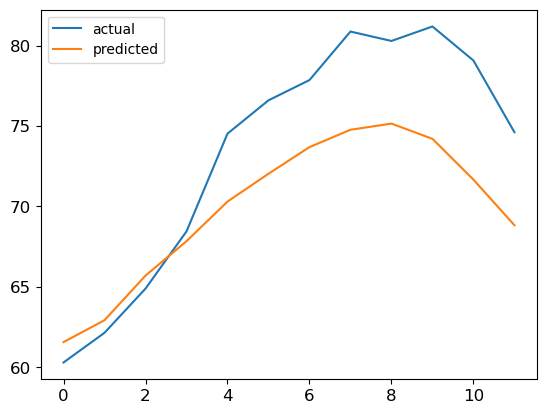

In [103]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=86)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

# Sliding window

Prior 18 hours predicts next 6 hours

In [104]:
steps_for_prediction = 18
steps_to_predict = 6

#Be careful: sums to 24 hours

In [105]:
train

array([[-1.98631703e+00, -1.83649120e+00, -1.85053737e+00, ...,
        -1.46192662e+00, -1.45256251e+00, -1.42447016e+00],
       [ 4.01532160e-01,  4.48352732e-01,  4.85809190e-01, ...,
         1.29580509e+00,  1.07574840e+00,  1.01956372e+00],
       [-1.19504936e+00, -1.19973142e+00, -1.26528022e+00, ...,
        -1.03117735e+00, -1.29337256e+00, -1.48533691e+00],
       ...,
       [ 2.09567813e-01,  3.12573072e-01,  3.35983359e-01, ...,
         1.33326155e+00,  1.23025629e+00,  9.82107257e-01],
       [-1.12476250e-03,  1.29214092e-02, -5.26273921e-02, ...,
         1.10384075e+00,  8.88466112e-01,  5.60722106e-01],
       [ 7.43322338e-01,  6.63727365e-01,  5.93496507e-01, ...,
         1.08979457e+00,  8.60373769e-01,  7.19912052e-01]])

In [106]:
train.flatten().shape

(4824,)

In [107]:
train_inputs_sw = []
train_target_sw = []

for i in range(0,4824-24):
    input_row = train.flatten()[i:i+steps_for_prediction]
    target_row = train.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    train_inputs_sw.append((input_row))
    train_target_sw.append((target_row))

In [108]:
train_inputs = np.vstack(train_inputs_sw)

train_targets = np.vstack(train_target_sw)

In [109]:
train_targets.shape

(4800, 6)

In [110]:
# Repeat for test

test_inputs_sw = []
test_target_sw = []

for i in range(0,test.flatten().shape[0]-24):
    input_row = test.flatten()[i:i+steps_for_prediction]
    target_row = test.flatten()[i+steps_for_prediction:i+steps_for_prediction+steps_to_predict]
    test_inputs_sw.append((input_row))
    test_target_sw.append((target_row))
    
test_inputs = np.vstack(test_inputs_sw)

test_targets = np.vstack(test_target_sw)

# GRU

In [111]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[18, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(steps_to_predict, activation=None)
])

In [112]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_inputs, train_targets, epochs=30)

Epoch 1/30
150/150 [==============================] - 6s 14ms/step - loss: 0.5264
Epoch 2/30
150/150 [==============================] - 2s 15ms/step - loss: 0.3222
Epoch 3/30
150/150 [==============================] - 2s 15ms/step - loss: 0.2900
Epoch 4/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2715
Epoch 5/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2592
Epoch 6/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2464
Epoch 7/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2435
Epoch 8/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2359
Epoch 9/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2314
Epoch 10/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2305
Epoch 11/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2273
Epoch 12/30
150/150 [==============================] - 2s 14ms/step - loss: 0.2244
Epoch 13/30
1

### Predictions

In [113]:
#Predict:
y_pred = model.predict(test_inputs)

65/65 [==============================] - 1s 7ms/step


In [114]:
#Remember, these are standardized values. 

actual = pd.DataFrame(scaler.inverse_transform(test_targets))
predicted = pd.DataFrame(scaler.inverse_transform(y_pred))

In [115]:
actual

,0,1,2,3,4,5
0,88.751,88.868,89.531,89.063,87.197,86.021
1,88.868,89.531,89.063,87.197,86.021,75.875
2,89.531,89.063,87.197,86.021,75.875,75.155
3,89.063,87.197,86.021,75.875,75.155,74.255
4,87.197,86.021,75.875,75.155,74.255,74.840
...,...,...,...,...,...,...
2059,76.781,76.880,77.393,78.770,79.073,79.235
2060,76.880,77.393,78.770,79.073,79.235,78.611
2061,77.393,78.770,79.073,79.235,78.611,78.470
2062,78.770,79.073,79.235,78.611,78.470,78.722


In [116]:
predicted

,0,1,2,3,4,5
0,87.859291,87.975037,87.684135,86.891357,85.142288,82.599434
1,88.738625,88.679459,87.756096,85.516365,82.576469,79.689476
2,88.624794,88.664848,87.163231,83.731537,80.300293,76.800613
3,89.041595,88.589569,86.112190,81.165001,77.248077,74.127426
4,88.729927,86.377869,81.961411,76.877296,73.969620,71.693298
...,...,...,...,...,...,...
2059,77.201958,78.420853,80.129669,82.420624,84.359550,84.927368
2060,77.649498,79.162277,81.007278,82.893333,84.741249,85.115097
2061,77.646515,79.555153,81.452629,82.957710,84.826057,84.954323
2062,78.428223,80.140167,81.811081,83.072205,84.633820,84.930046


In [117]:
mean_squared_error(actual, predicted)

20.573730234627824

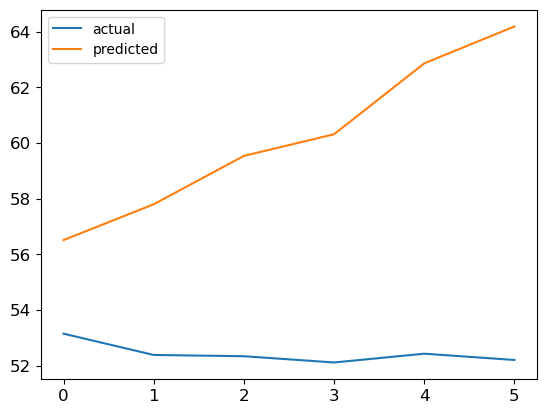

In [118]:
# Plot a random row to see the accuracy of predictions

random_row = np.random.randint(low=0, high=2063)

plt.plot(actual.iloc[random_row], label='actual')
plt.plot(predicted.iloc[random_row], label='predicted')

plt.legend()
plt.show()

## We could try using 6 steps to predict the next 6 steps (maybe 12 steps is too long)